In [1]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

results_dir = Path("/gpfs/commons/home/daknowles/pooledRBPs/results/HNRNPK")

/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
reps = {"rep1", "rep2"}

merged = { 
    rep:pd.read_csv(
    results_dir / ("merged_%s.tsv.gz" % rep), 
    index_col = False, 
    sep = "\t" )
          for rep in reps }

dat_sub = { 
    rep:pd.read_csv(
    results_dir / ("filtered_%s.tsv.gz" % rep), 
    index_col = False, 
    sep = "\t" )
          for rep in reps }

# Run beta models

This can't handle replicates. 

Learned hyperparameters: {'input_conc': 78.77433013916016, 'input_count_conc': 239.31582641601562, 'IP_conc': 72.72130584716797, 'IP_count_conc': 407.6448974609375}


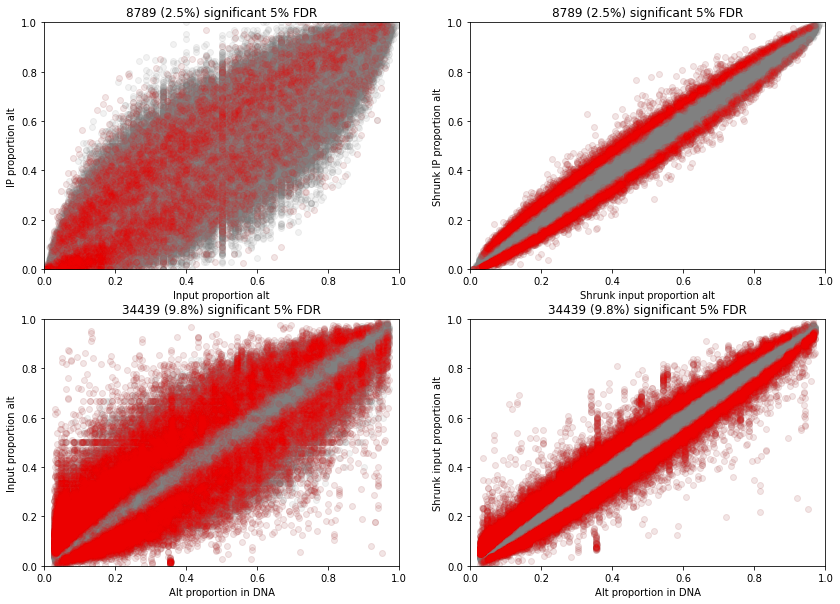

Learned hyperparameters: {'input_conc': 75.19886016845703, 'input_count_conc': 213.85614013671875, 'IP_conc': 65.0174331665039, 'IP_count_conc': 385.0903015136719}


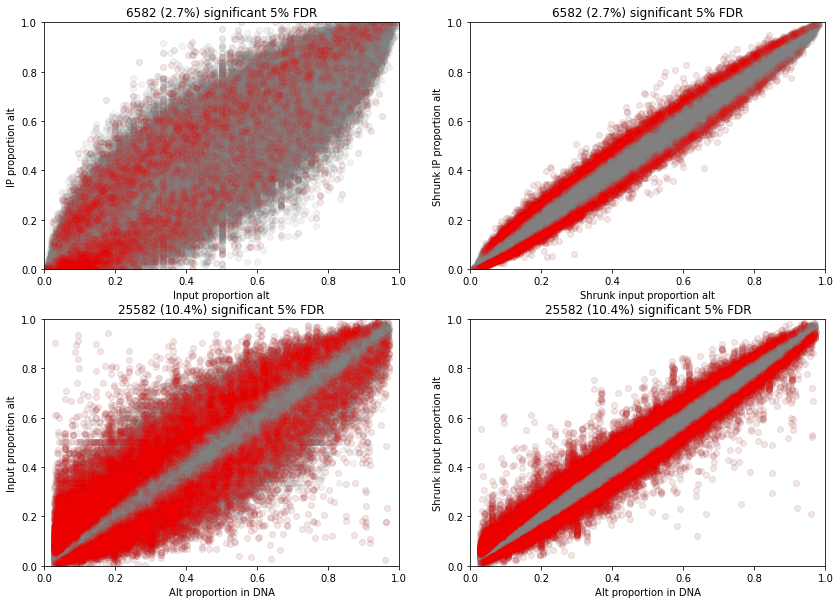

In [7]:
results = {}

for rep in dat_sub:

    results[rep] = beta_model.fit_and_save(
        dat_sub[rep], 
        results_dir / (
            "beta_new" 
            + ("_struct" if use_structured_guide else "")
            + ("_%s.tsv.gz" % rep)),
        use_structured_guide = use_structured_guide,
        iterations = 1000,
        device = device)
    
    beta_model.make_plots(results[rep], fdr_threshold = fdr_threshold)
    

# Gaussian model without replicates

Could also run this with the mean field guide. 

Learned hyperparameters: {'ase_scale': 0.22483785450458527, 'input_count_conc': 380.28240966796875, 'asb_scale': 0.24617576599121094, 'IP_count_conc': 358.04669189453125, 'ase_t_df': 4.511422634124756, 'asb_t_df': 33.067710876464844}


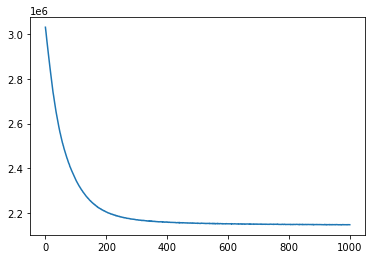

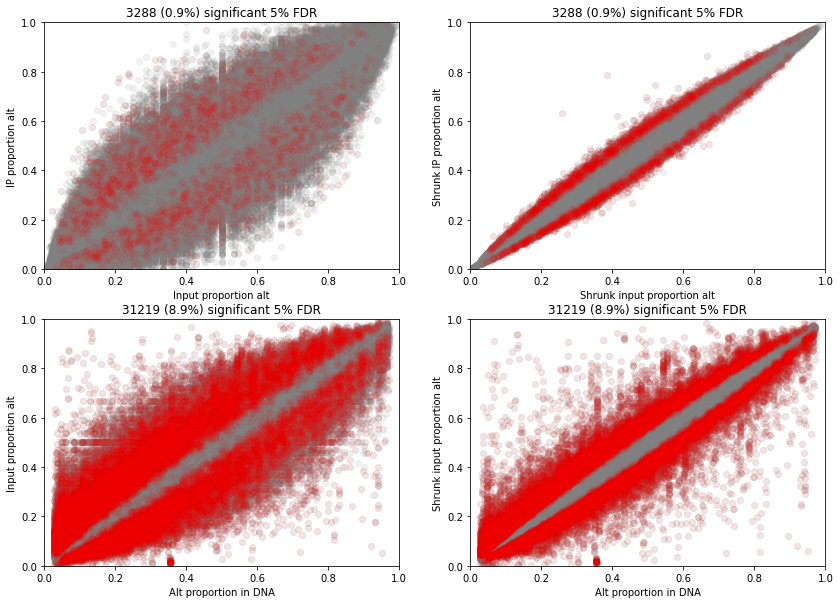

Learned hyperparameters: {'ase_scale': 0.2249140441417694, 'input_count_conc': 380.6408996582031, 'asb_scale': 0.24605706334114075, 'IP_count_conc': 357.553466796875, 'ase_t_df': 4.525147438049316, 'asb_t_df': 32.9388313293457}


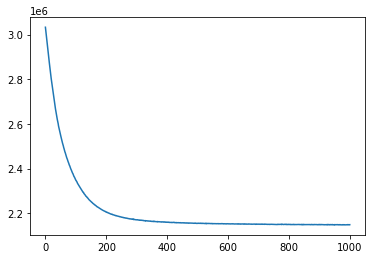

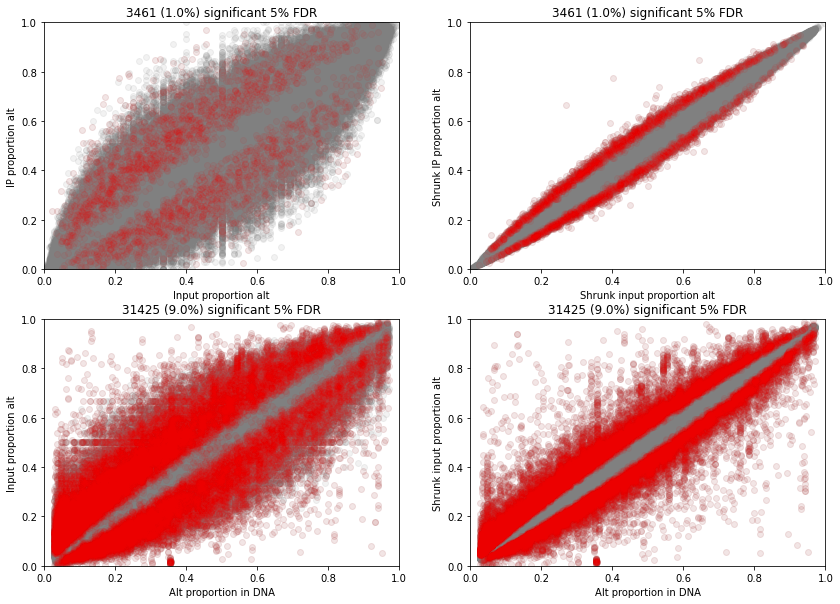

In [27]:
reload(beta_model)
reload(gaussian_model)
results = {}
fit_hypers = {}
for rep in dat_sub:
    
    results[rep], fit_hypers[rep] = gaussian_model.fit_and_save(
        dat_sub[rep], 
        results_dir / (
            "normal" 
            + ("_struct" if use_structured_guide else "") 
            + ("_%s.tsv.gz" % rep)),
        use_structured_guide = use_structured_guide,
        iterations = 1000,
        plot = True,
        device = device)
    
    beta_model.make_plots(results[rep], fdr_threshold = fdr_threshold)

# Replicates model

In [6]:
reload(gaussian_model)
rep_results, fit_hypers = gaussian_model.fit_replicates_and_save(
    dat_sub, 
    results_dir / (
        "rep" 
        + ("_struct" if use_structured_guide else "") 
        + "_results"),
    learn_t_dof = False, 
    Laplace = False,
    studentT = False, 
    use_structured_guide = use_structured_guide,
    iterations = 1000,
    device = device)

KeyboardInterrupt: 

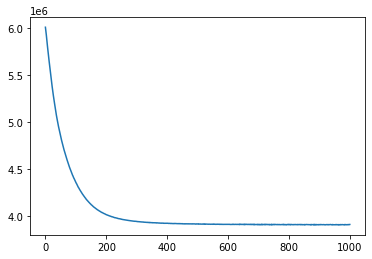

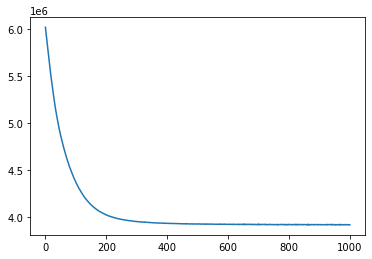

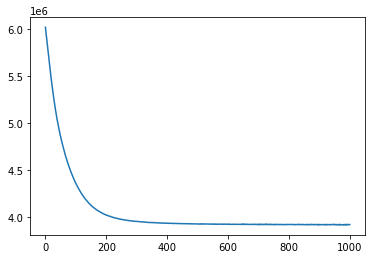

In [5]:
rep_results, fit_hypers_t = gaussian_model.fit_replicates_and_save(
    dat_sub, 
    results_dir / (
        "rep_learnt_studentT.tsv.gz"),
    learn_t_dof = True, 
    Laplace = False,
    studentT = True,
    use_structured_guide = use_structured_guide,
    iterations = 1000,
    device = device)

rep_results, fit_hypers_t3 = gaussian_model.fit_replicates_and_save(
    dat_sub, 
    results_dir / (
        "rep_fixed3_studentT.tsv.gz"),
    learn_t_dof = False, 
    Laplace = False,
    studentT = True,
    use_structured_guide = use_structured_guide,
    iterations = 1000,
    device = device)

rep_results, fit_hypers_Laplace = gaussian_model.fit_replicates_and_save(
    dat_sub, 
    results_dir / (
        "rep_Laplace.tsv.gz"),
    learn_t_dof = False, 
    Laplace = True,
    studentT = False,
    use_structured_guide = use_structured_guide,
    iterations = 1000,
    device = device)

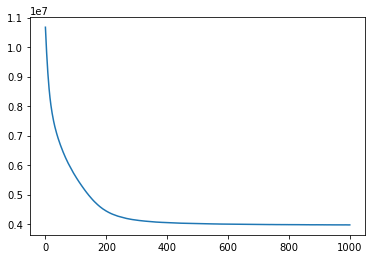

In [6]:
reload(gaussian_model)
rep_results, fit_hypers_unstruct_t = gaussian_model.fit_replicates_and_save(
    dat_sub, 
    results_dir / ( "rep_unstruct_learnt_studentT.tsv.gz"),
    learn_t_dof = True, 
    Laplace = False,
    studentT = True,
    use_structured_guide = False,
    iterations = 1000,
    device = device)

In [7]:
fit_hypers_t

{'ase_scale': 0.27654141187667847,
 'input_count_conc': 6178.39111328125,
 'asb_scale': 0.3110821843147278,
 'IP_count_conc': 5707.20458984375,
 'ase_t_df': 4.35184907913208,
 'asb_t_df': 13.782572746276855}

In [21]:
for name in pyro.get_param_store().get_all_param_names():
    print(name, pyro.param(name).data.numpy())

AutoGuideList.0.loc [-0.4476523   0.01697873 -0.0441652  ... -0.05871073  0.10334986
  0.06875268]
AutoGuideList.0.scale [0.18573457 0.1452342  0.18320952 ... 0.16999285 0.13135494 0.09685525]
AutoGuideList.1.ase_scale 0.23581937
AutoGuideList.1.input_count_conc 648.2578
AutoGuideList.1.asb_scale 0.1998093
AutoGuideList.1.IP_count_conc 353.5402
AutoGuideList.1.ase_t_df 3.6356285
AutoGuideList.1.asb_t_df 17.024227


In [22]:
pyro.get_param_store().named_parameters()

dict_items([('AutoGuideList.0.loc', Parameter containing:
tensor([-0.4477,  0.0170, -0.0442,  ..., -0.0587,  0.1033,  0.0688],
       requires_grad=True)), ('AutoGuideList.0.scale', Parameter containing:
tensor([-1.5891, -1.8559, -1.6041,  ..., -1.6858, -1.9635, -2.2857],
       requires_grad=True)), ('AutoGuideList.1.ase_scale', Parameter containing:
tensor(-1.4447, requires_grad=True)), ('AutoGuideList.1.input_count_conc', Parameter containing:
tensor(6.4743, requires_grad=True)), ('AutoGuideList.1.asb_scale', Parameter containing:
tensor(-1.6104, requires_grad=True)), ('AutoGuideList.1.IP_count_conc', Parameter containing:
tensor(5.8680, requires_grad=True)), ('AutoGuideList.1.ase_t_df', Parameter containing:
tensor(1.2908, requires_grad=True)), ('AutoGuideList.1.asb_t_df', Parameter containing:
tensor(2.8346, requires_grad=True))])

In [35]:
pyro.param('AutoGuideList.0.loc')

Parameter containing:
tensor([ 1.3196,  0.8942, -0.7755,  ...,  0.2569,  0.3008,  0.8105],
       requires_grad=True)

In [8]:
fit_hypers

{'ase_scale': 0.37538081407546997,
 'input_count_conc': 6176.6591796875,
 'asb_scale': 0.3414115011692047,
 'IP_count_conc': 5703.86376953125}

In [9]:
fit_hypers_Laplace

{'ase_scale': 0.2708287239074707,
 'input_count_conc': 6177.236328125,
 'asb_scale': 0.26630139350891113,
 'IP_count_conc': 5831.01904296875}

In [10]:
fit_hypers_t

{'ase_scale': 0.27654141187667847,
 'input_count_conc': 6178.39111328125,
 'asb_scale': 0.3110821843147278,
 'IP_count_conc': 5707.20458984375,
 'ase_t_df': 4.35184907913208,
 'asb_t_df': 13.782572746276855}

In [11]:
fit_hypers_t3

{'ase_scale': 0.2513282597064972,
 'input_count_conc': 6107.9248046875,
 'asb_scale': 0.2512616217136383,
 'IP_count_conc': 5828.73388671875}

In [64]:
for assay in ["input","IP"]:
    for allele in ["alt","ref","total"]: 
        rep_results["%sCount_%s" % (allele, assay)] = rep_results["%sCount_%s_%i" % (allele, assay, 1)] + \
            rep_results["%sCount_%s_%i" % (allele, assay, 2)]
    rep_results["%s_ratio" % assay] = rep_results["altCount_%s" % assay] / rep_results["totalCount_%s" % assay]
    for rep_idx in [1,2]:
        rep_results["shrunk_%s_ratio_%i" % (assay,rep_idx)] = scipy.special.logit(rep_results["pred_ratio_%i" % rep_idx]) + rep_results.ase_loc + (
            0 if (assay=="input") else rep_results.asb_loc)

Plot combined counts for reps 1 and 2. 

Text(0.5, 1.0, 'Both reps 1391 (0.4%) significant 5% FDR')

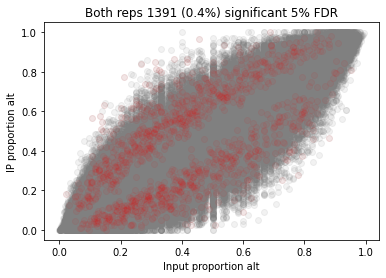

In [73]:
plt.scatter(dat_here.input_ratio, dat_here.IP_ratio,alpha=0.1, color="gray")
dat_ss = dat_here[dat_here.asb_q < fdr_threshold]
plt.scatter(dat_ss.input_ratio, dat_ss.IP_ratio,alpha=0.05, color = "red")
plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
plt.title('Both reps %i (%.1f%%) significant %.0f%% FDR' % ((dat_here.asb_q < fdr_threshold).sum(), 
                                                  100. * (dat_here.asb_q < fdr_threshold).mean(), 
                                                  fdr_threshold*100))

Plots for individual replicates, but showing significance for the joint model. 

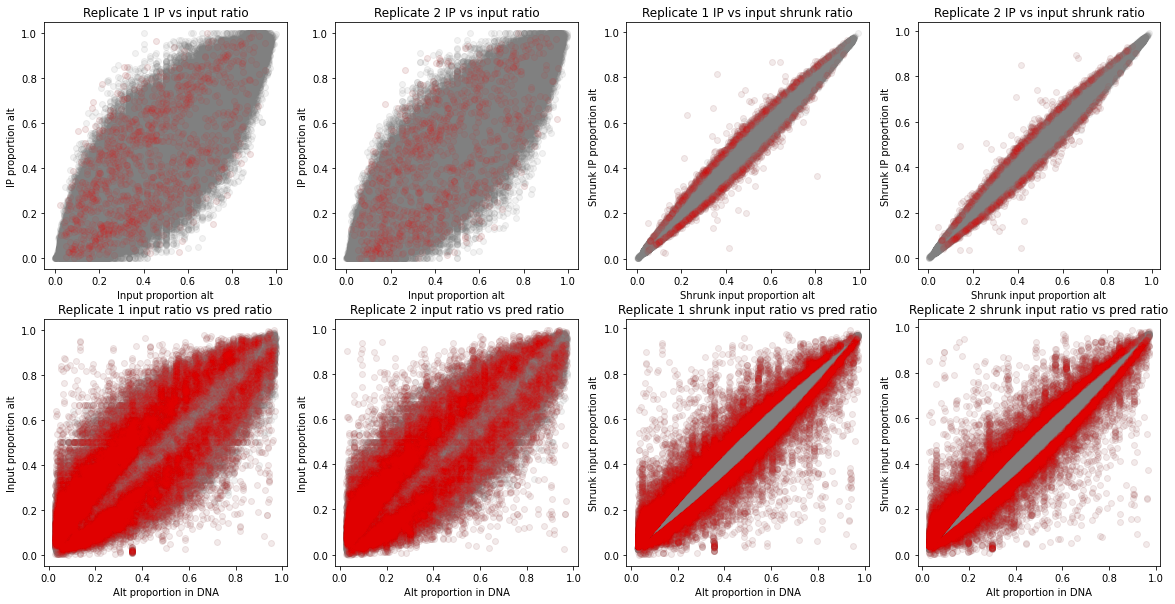

In [76]:
logistic = lambda g: 1./(1.+np.exp(-g))

plt.figure(figsize=(20,10))

for rep_idx in [1,2]:
    
    dat_here = rep_results[rep_results["totalCount_input_%i" % rep_idx] > 0]
    
    plt.subplot(2,4,rep_idx)
    plt.scatter(dat_here["input_ratio_%i" % rep_idx], dat_here["IP_ratio_%i" % rep_idx],alpha=0.1, color="gray")
    dat_ss = dat_here[dat_here.asb_q < fdr_threshold]
    plt.scatter(dat_ss["input_ratio_%i" % rep_idx], dat_ss["IP_ratio_%i" % rep_idx],alpha=0.05, color = "red")
    plt.xlabel("Input proportion alt"); plt.ylabel("IP proportion alt")
    plt.title('Replicate %i IP vs input ratio' % rep_idx)

    plt.subplot(2,4,2+rep_idx)
    plt.scatter( logistic(dat_here["shrunk_input_ratio_%i" % rep_idx]), logistic(dat_here["shrunk_IP_ratio_%i" % rep_idx]),alpha=0.1, color="gray")
    dat_ss = dat_here[dat_here.asb_q < fdr_threshold]
    plt.scatter(logistic(dat_ss["shrunk_input_ratio_%i" % rep_idx]), logistic(dat_ss["shrunk_IP_ratio_%i" % rep_idx]),alpha=0.03, color = "red")
    plt.xlabel("Shrunk input proportion alt"); plt.ylabel("Shrunk IP proportion alt")
    plt.title('Replicate %i IP vs input shrunk ratio' % rep_idx)

    plt.subplot(2,4,4+rep_idx)
    plt.scatter( dat_here["pred_ratio_%i" % rep_idx], dat_here["input_ratio_%i" % rep_idx],alpha=0.1, color="gray")
    dat_ss = dat_here[dat_here.ase_q < fdr_threshold]
    plt.scatter( dat_ss["pred_ratio_%i" % rep_idx], dat_ss["input_ratio_%i" % rep_idx],alpha=0.03, color = "red")
    plt.xlabel("Alt proportion in DNA"); plt.ylabel("Input proportion alt")
    plt.title('Replicate %i input ratio vs pred ratio' % rep_idx)

    plt.subplot(2,4,6+rep_idx)
    plt.scatter( dat_here["pred_ratio_%i" % rep_idx], logistic(dat_here["shrunk_input_ratio_%i" % rep_idx]),alpha=0.1, color="gray")
    dat_ss = dat_here[dat_here.ase_q < fdr_threshold]
    plt.scatter( dat_ss["pred_ratio_%i" % rep_idx], logistic(dat_ss["shrunk_input_ratio_%i" % rep_idx]),alpha=0.03, color = "red")
    plt.xlabel("Alt proportion in DNA"); plt.ylabel("Shrunk input proportion alt")
    plt.title('Replicate %i shrunk input ratio vs pred ratio' % rep_idx)


In [75]:
rep_results

,contig,position_hg19,variantID,refAllele,altAllele,position,refCount_input_1,altCount_input_1,totalCount_input_1,input_ratio_1,...,altCount_IP,refCount_IP,totalCount_IP,IP_ratio,shrunk_input_ratio,shrunk_IP_ratio,shrunk_input_ratio_1,shrunk_input_ratio_2,shrunk_IP_ratio_1,shrunk_IP_ratio_2
0,chr10,294953,rs1017361,A,G,249013,18,109,127,0.858268,...,34,2,36,0.944444,2.360132,2.407049,2.360132,-inf,2.407049,-inf
1,chr10,320954,rs10903832,A,G,275014,98,24,122,0.196721,...,6,30,36,0.166667,-1.421873,-1.399966,-1.421873,-inf,-1.399966,-inf
2,chr10,325134,rs12357593,C,T,279194,10,4,14,0.285714,...,5,33,38,0.131579,-1.358743,-1.425559,-1.358743,-inf,-1.425559,-inf
3,chr10,327780,rs7908298,C,T,281840,11,7,18,0.388889,...,14,20,34,0.411765,-0.339653,-0.298221,-0.339653,-inf,-0.298221,-inf
4,chr10,347752,rs7918643,C,T,301812,12,9,21,0.428571,...,10,42,52,0.192308,-0.914372,-1.052445,-0.914372,-inf,-1.052445,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385766,chr9,140656514,rs7032719,T,C,137762062,0,0,0,0.000000,...,10,22,32,0.312500,-inf,-inf,-inf,-0.313368,-inf,-0.340235
385767,chr9,140709605,rs67116066,A,G,137815153,0,0,0,0.000000,...,5,72,77,0.064935,-inf,-inf,-inf,-2.163874,-inf,-2.123441
385768,chr9,140709647,rs72766964,A,G,137815195,0,0,0,0.000000,...,5,94,99,0.050505,-inf,-inf,-inf,-2.257456,-inf,-2.330899
385769,chr9,140866826,rs12352971,G,T,137972374,0,0,0,0.000000,...,22,43,65,0.338462,-inf,-inf,-inf,-1.282179,-inf,-1.010658
